In [9]:
import time
from functools import wraps
from itertools import groupby

import mlrose_hiive as mlrose
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def generate_tsp_problem(number_of_cities=10, seed=None, maximize=True):
    """
    Generate a random Travelling Salesman Problem (TSP) with `num_cities`.
    
    Args:
    - num_cities (int): The number of cities (nodes) for the TSP.
    - seed (int or None): Seed for reproducibility. Default is None.
    - maximize( bool or None): 
    
    Returns:
    - fitness: An instance of mlrose.TravellingSales fitness function.
    - coords: List of tuples representing city coordinates.
    """
    if seed is not None:
        np.random.seed(seed)
        
    if maximize:
        maximize_multiplier = -1
    else:
        maximize_multiplier = 1

    class MaxTravellingSales(mlrose.TravellingSales):
        def evaluate(self, state):
            return maximize_multiplier*super().evaluate(state)
        
    coords = [(np.random.uniform(0, 100), np.random.uniform(0, 100)) for _ in range(number_of_cities)]
    fitness = MaxTravellingSales(coords=coords)
    problem = mlrose.TSPOpt(length = number_of_cities, fitness_fn = fitness, maximize=maximize)
    
    return problem

In [11]:
def plot_fitness_iteration(problem_curves, title, x="Iteration", y="Fitness", algo_name=False):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    for problem, curve, best_fitness, best_state, time_taken in problem_curves:
        label = (problem if algo_name else f'# of Cities:{problem.length}') + f' | fitness: {best_fitness:.3f} | time: {time_taken:.3f}'
        plt.plot(range(len(curve)), curve[:, 0], label=label)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

In [12]:
problems = [generate_tsp_problem(i) for i in range(5, 30, 2)]

In [13]:
def wall_clock_time(func):
    @wraps(func)  
    def wrapper(*args, **kwargs):
        start_time = time.time()  
        result = func(*args, **kwargs) 
        end_time = time.time()  
        elapsed_time = end_time - start_time  
        return *result, elapsed_time,
    return wrapper

In [14]:
@wall_clock_time
def simulated_annealing(problem, max_attempts=200, max_iters=2500, init_temp=0.1, random_state=42, *args, **kwargs):
    # Solve problem using simulated annealing
    schedule = mlrose.ExpDecay(init_temp)
    best_state, best_fitness, sa_curve = mlrose.simulated_annealing(
        problem,
        max_attempts=max_attempts,
        max_iters=max_iters,
        random_state=random_state,
        schedule=schedule,
        curve=True
    )
    return sa_curve, best_fitness, best_state,  

In [15]:
@wall_clock_time
def random_hill(problem, max_attempts=50, max_iters=2500, restarts=10, random_state=42, *args, **kwargs):
    # Solve problem using Random Hill
    best_state, best_fitness, rhc_curve = mlrose.random_hill_climb(problem,
                                                             max_attempts=max_attempts,
                                                             max_iters=max_iters,
                                                             random_state=random_state,
                                                             restarts=restarts,
                                                             curve=True)
    return rhc_curve, best_fitness, best_state,

In [16]:
@wall_clock_time
def mimic(problem, max_attempts=10, max_iters=2500, keep_pct=.25, pop_size=1000, random_state=42, *args, **kwargs):
    best_state, best_fitness, mimic_curve = mlrose.mimic(
        problem,
        max_attempts=max_attempts,
        max_iters=max_iters,
        random_state=random_state,
        pop_size=pop_size,
        keep_pct=keep_pct,
        curve=True
    )
    return mimic_curve, best_fitness, best_state,

In [17]:
@wall_clock_time
def genetic_algorithm(
    problem, max_attempts=20, max_iters=2500, mutation_prob=0.6, pop_size=400, random_state=42,
    pop_breed_percent=0.75, elite_dreg_ratio=0.99, *args, **kwargs
):
    best_state, best_fitness, gen_curve = mlrose.genetic_alg(
        problem,
        max_attempts=max_attempts, max_iters=max_iters, random_state=random_state,
        pop_size=pop_size, mutation_prob=mutation_prob, pop_breed_percent=pop_breed_percent,
        elite_dreg_ratio=elite_dreg_ratio, curve=True,
    )
    return gen_curve, best_fitness, best_state,

In [23]:
def get_group_by_max(data):
    return [[i[0]for i in sorted(group, key=lambda x: x[0][2], reverse=True)[:1]][0] for _, group in groupby(data, key=lambda x: x[1]['max_iters'])]

def different_problem_size_graph(fitness_algo, title, *args, **kwargs):
    curves = []
    for problem in problems:
        curve, best_fitness , best_state, time_taken = fitness_algo(problem, *args, **kwargs)
        curves.append([problem, curve, best_fitness, best_state, time_taken])
    plot_fitness_iteration(curves, title=title)    

def same_problem_graph(problem):
    # Define hyperparameters
    hyperparams = {
        "sa": {
            "max_attempts_list": [100, 200, 300, 500, 1000],
            "max_iterations_list": [500, 1000, 2000, 2500, 3000],
            "init_temp_list": [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9]
        },
        "rhc": {
            "max_attempts_list": [100, 200, 300, 500, 1000],
            "max_iterations_list": [500, 1000, 2000, 2500, 3000],
            "restarts_list": [0, 10, 20, 40, 50]
        },
        "mimic": {
            "max_attempts_list": [10, 20, 30, 40, 50],
            "max_iterations_list": [10 , 30,  50, 100, 200],
            #"keep_pct_list": [0.1, 0.2, 0.3, 0.4, 0.5],
            "pop_size_list": [100, 200, 500, 1000]
        },
        "ga": {
            "max_attempts_list": [10, 20, 30],
            "max_iterations_list": [10, 30, 50],
            "pop_size_ga_list": [100, 200, 500, 1000],
            #"pop_breed_percent_list": [0.3, 0.4, 0.5, 0.7, 0.9],
            #"elite_dreg_ratio_list": [0.3, 0.6, 0.8, 0.9],
            #"mutation_prob_list": [0.1, 0.2, 0.3, 0.4, 0.5]
        }
    }

    # Initialize curve lists
    curves = {
        "sa": [],
        "rhc": [],
        "mimic": [],
        "ga": []
    }

    # Utility function to run an algorithm with specific parameters and store the results
    def run_algorithm(algorithm, config, label):
        result = algorithm(problem, **config)
        curves[label].append([(f'Config: {config}', *result), config])

    # Iterating over hyperparameters

    # Simulated Annealing
    for max_iters in hyperparams["sa"]["max_iterations_list"]:
        for max_attempts in hyperparams["sa"]["max_attempts_list"]:
            for init_temp in hyperparams["sa"]["init_temp_list"]:
                config = {"max_attempts": max_attempts, "max_iters": max_iters, "init_temp": init_temp}
                run_algorithm(simulated_annealing, config, "sa")

    plot_fitness_iteration(
        get_group_by_max(curves['sa']),
        title=f'Simulated Annealing on problem size {problem.length}',
        algo_name=True
    )
    
    # Random Hill Climbing                
    for max_iters in hyperparams["rhc"]["max_iterations_list"]:
        for max_attempts in hyperparams["rhc"]["max_attempts_list"]:
            for restarts in hyperparams["rhc"]["restarts_list"]:
                config = {"max_attempts": max_attempts, "max_iters": max_iters, "restarts": restarts}
                run_algorithm(random_hill, config, "rhc")
    
    plot_fitness_iteration(
        get_group_by_max(curves['rhc']),
        title=f'Random Hill Climb on problem size {problem.length}',
        algo_name=True
    )
    
    # MIMIC
    for max_iters in hyperparams["mimic"]["max_iterations_list"]:
        for max_attempts in hyperparams["mimic"]["max_attempts_list"]:
            for pop_size in hyperparams["mimic"]["pop_size_list"]:
                #for keep_pct in hyperparams["mimic"]["keep_pct_list"]:
                    config = {"max_attempts": max_attempts, "max_iters": max_iters,"pop_size": pop_size}
                    run_algorithm(mimic, config, "mimic")
    plot_fitness_iteration(
        get_group_by_max(curves['mimic']),
        title=f'MIMIC on problem size {problem.length}',
        algo_name=True
    )

    # Genetic Algorithm    
    for max_iters in hyperparams["ga"]["max_iterations_list"]:
        for max_attempts in hyperparams["ga"]["max_attempts_list"]:
            for pop_size in hyperparams["ga"]["pop_size_ga_list"]:
                #for pop_breed_percent in hyperparams["ga"]["pop_breed_percent_list"]:
                    #for elite_dreg_ratio in hyperparams["ga"]["elite_dreg_ratio_list"]:
                        #for mutation_prob in hyperparams["ga"]["mutation_prob_list"]:
                            config = {
                                "max_attempts": max_attempts, "max_iters": max_iters,
                                "pop_size": pop_size#, "pop_breed_percent": pop_breed_percent,
                                #"elite_dreg_ratio": elite_dreg_ratio, "mutation_prob": mutation_prob
                            }
                            run_algorithm(genetic_algorithm, config, "ga")
    plot_fitness_iteration(
        get_group_by_max(curves['ga']),
        title=f'Genetic Algorithm on problem size {problem.length}',
        algo_name=True
    )
    

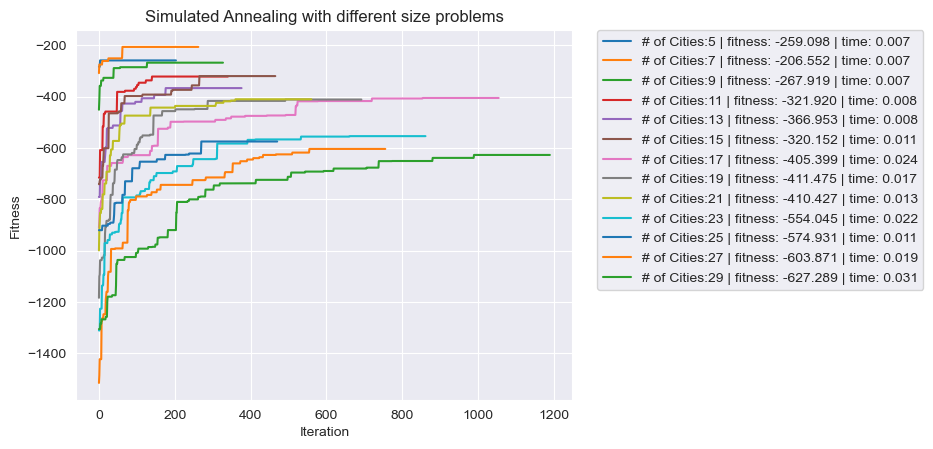

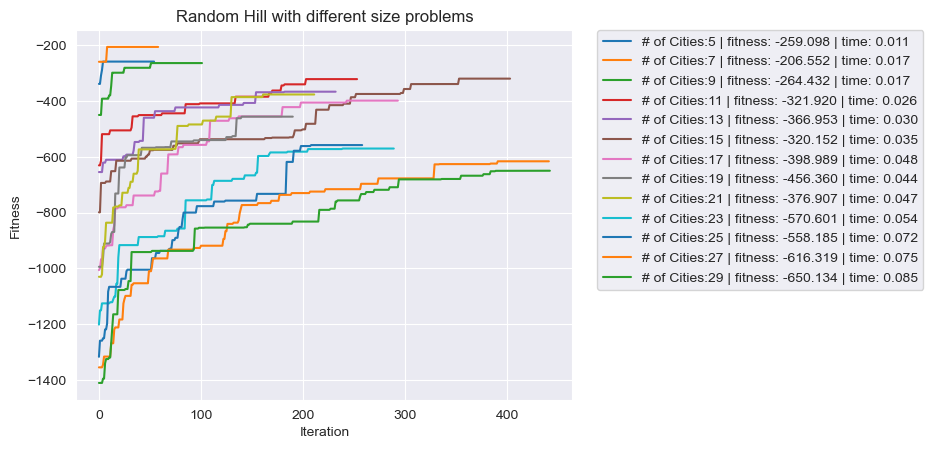

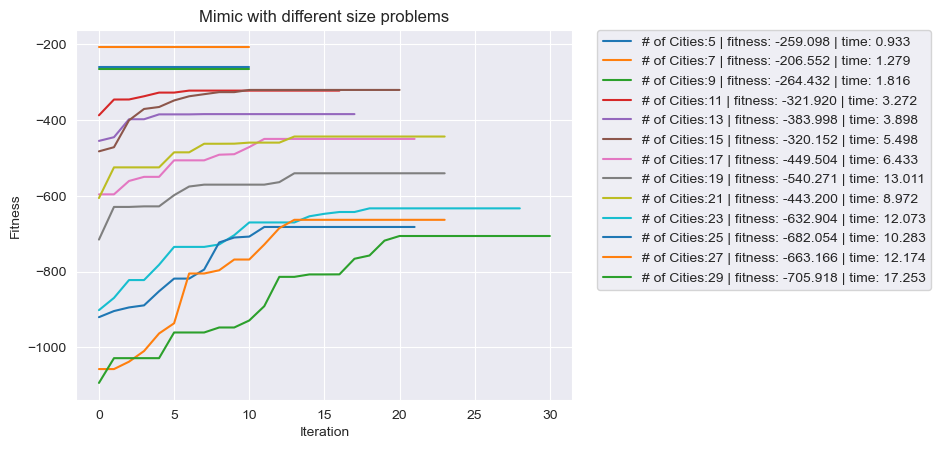

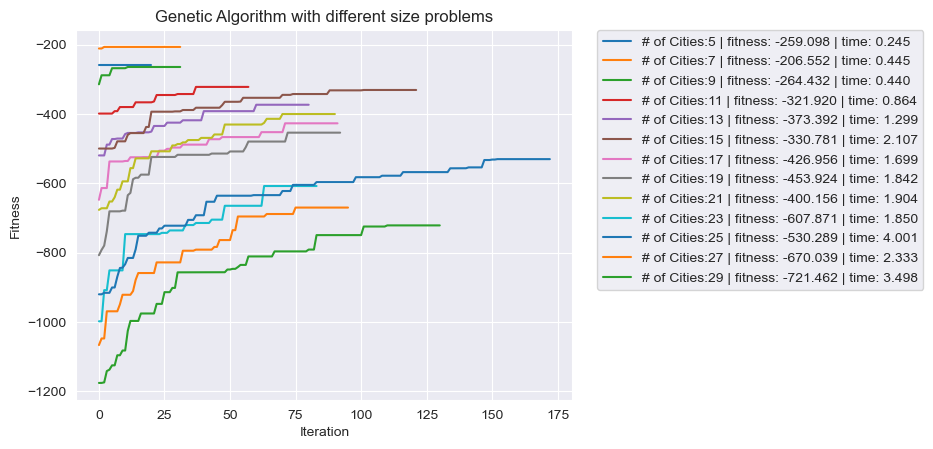

In [19]:
different_problem_size_graph(simulated_annealing, title='Simulated Annealing with different size problems')
different_problem_size_graph(random_hill, title='Random Hill with different size problems')
different_problem_size_graph(mimic, title='Mimic with different size problems')
different_problem_size_graph(genetic_algorithm, title='Genetic Algorithm with different size problems')

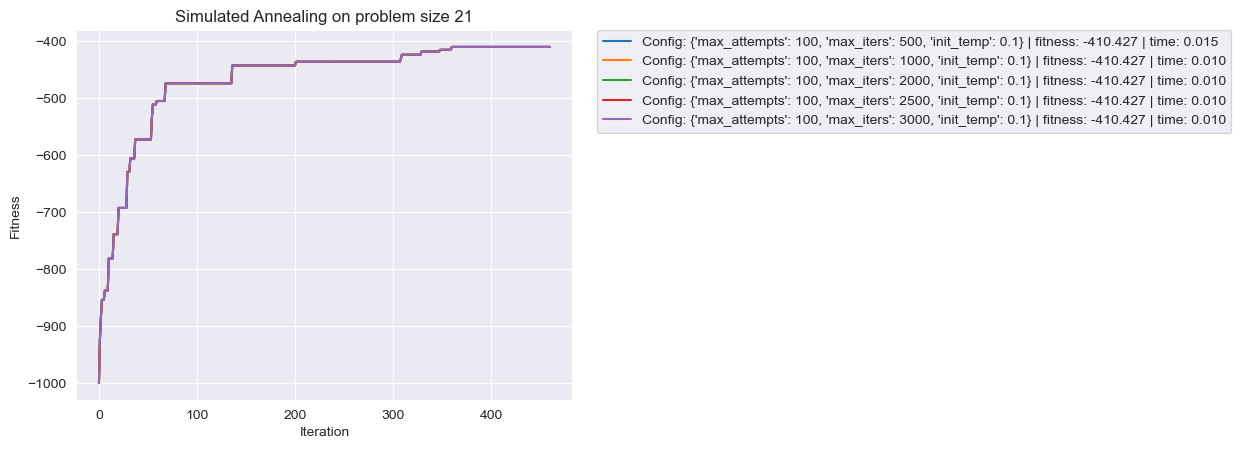

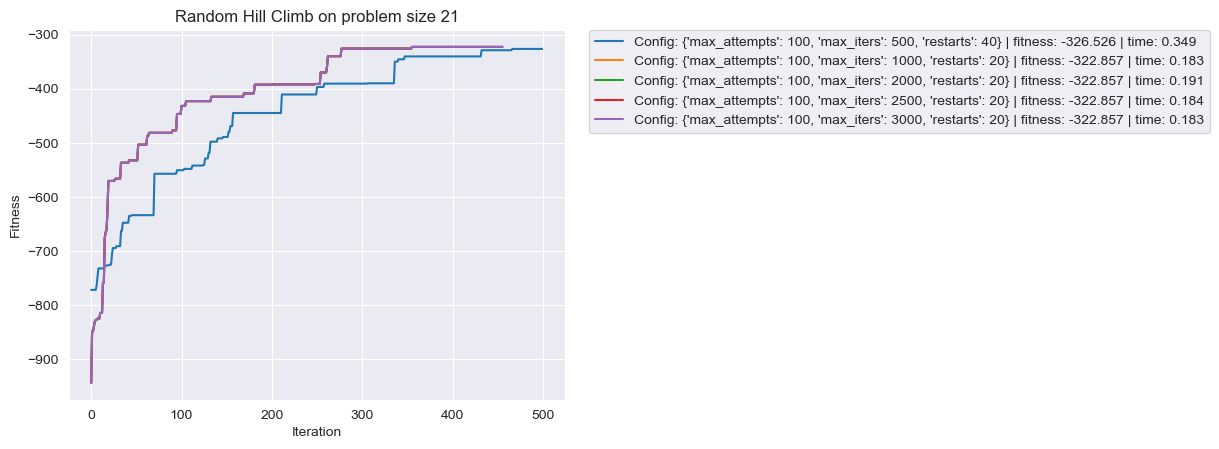

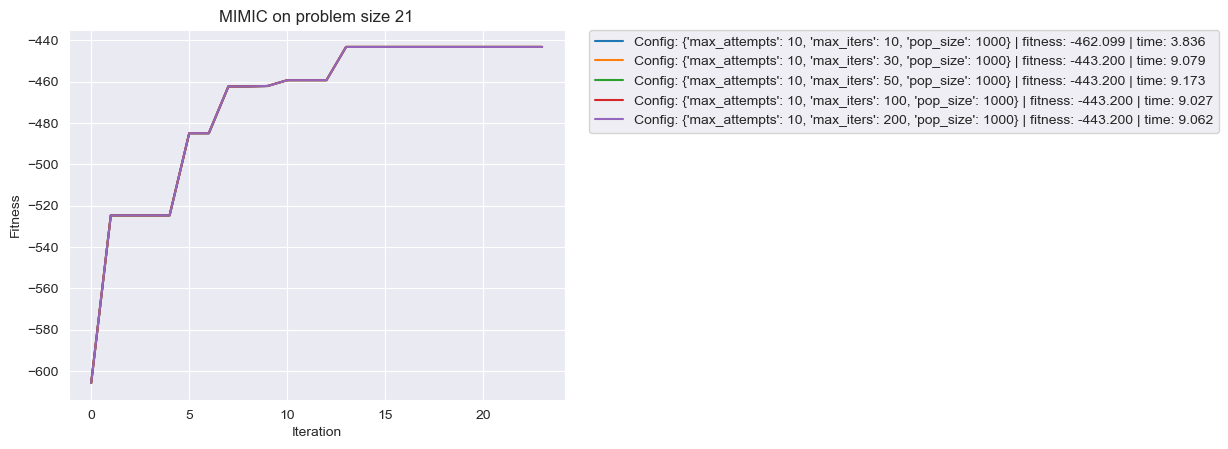

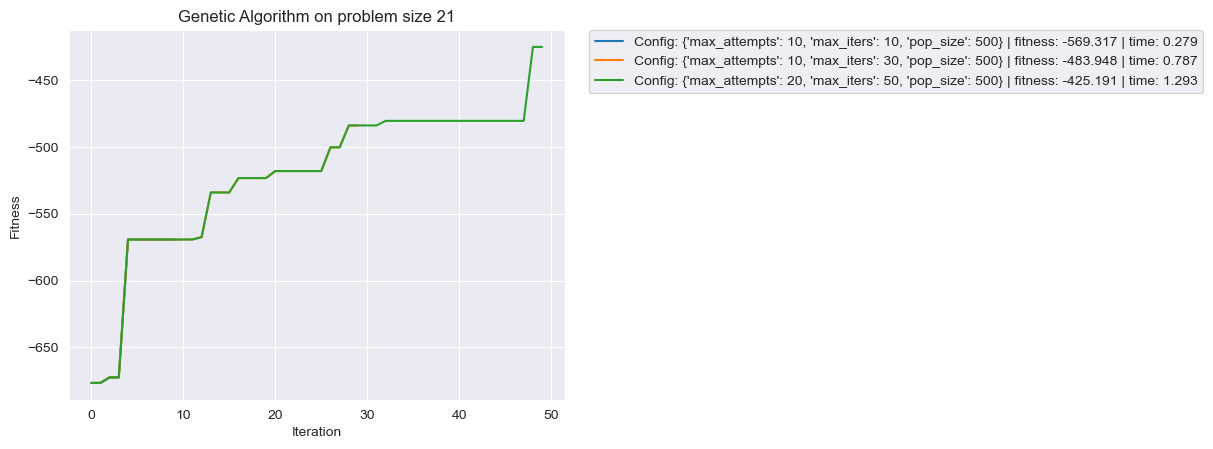

In [24]:
same_problem_graph(problems[8])